In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import numpy as np
from datetime import datetime, timedelta
import os
from PIL import ImageFile

# Getting all paths

In [5]:
# get content of https://www.stampworld.com/en/sitemap/
def get_sitemap():
    url = "https://www.stampworld.com/en/sitemap/"
    
    # Fetch the HTML content
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
    else:
        html = None

    soup = BeautifulSoup(html, 'html.parser')
    
    return soup

def get_country_links(soup):
    # get first table in div with class "sitemap"
    table = soup.find("div", class_="sitemap").find_all("table")[0]

    # get all links and the corresponding country names
    country_links = {}
    # find all a tags in the table
    for link in table.find_all("a"):
        country_links[link.text] = link["href"]

    return country_links

In [6]:
sitemap = get_sitemap()

country_links = get_country_links(sitemap)

### Get year paths

and the category

In [7]:
# loop over all countries and get the links to the stamps
def get_stamp_links(country_links):

    # create empty df to store the links
    stamp_links = pd.DataFrame(columns=["country", "category", "year", "url"])

    for country, url in tqdm(country_links.items(), desc="Processing countries"):
        response = requests.get("https://www.stampworld.com" + url)
        if response.status_code == 200:
            html = response.text
        else:
            html = None

        soup = BeautifulSoup(html, 'html.parser')

        # in div with class "sitemap" h2 and table are alternating
        # get all h2 tags which contain the category
        h2_tags = soup.find("div", class_="sitemap").find_all("h2")

        # get all tables
        tables = soup.find("div", class_="sitemap").find_all("table")

        # loop over all h2 tags and tables
        for h2, table in zip(h2_tags, tables):
            # get the category
            category = h2.text

            # find all a tags in the table
            for link in table.find_all("a"):
                # get the year
                year = link.text

                # get the url
                stamp_url = link["href"]

                # append to df
                stamp_links = pd.concat([stamp_links, pd.DataFrame([[country, category, year, stamp_url]], columns=["country", "category", "year", "url"])], ignore_index=True)
        
        
    return stamp_links

In [ ]:
stamp_links = get_stamp_links(country_links)

In [9]:
len(stamp_links)
# 29333

29333

### get set links

In [14]:
# loop over all stamp links and get the set links
def get_set_links(stamp_links):
    # create empty df to store the links
    set_links = pd.DataFrame(columns=["country", "category", "year", "setName", "url"])

    for index, row in tqdm(stamp_links.iterrows(), total=len(stamp_links), desc="Processing stamps"):
        response = requests.get("https://www.stampworld.com" + row["url"])
        if response.status_code == 200:
            html = response.text
        else:
            html = None
            print("Error for", row["url"])

        soup = BeautifulSoup(html, 'html.parser')

        # there are divs with id which starts with "group_box_"
        group_boxes = soup.find_all("div", id=re.compile("group_box_"))

        for group_box in group_boxes:
            # get first a tag in div with class "table_header"
            table_header = group_box.find("div", class_="table_header")
            set_name = table_header.find("a").text.strip()

            # replace all \n with empty string
            set_name = set_name.replace("\n", "")
            # replace all repeated spaces with single space
            set_name = re.sub(r"\s+", " ", set_name)

            # get the url
            set_url = table_header.find("a")["href"]

            # append to df
            set_links = pd.concat([set_links, pd.DataFrame([[row["country"], row["category"], row["year"], set_name, set_url]], columns=["country", "category", "year", "setName", "url"])], ignore_index=True)

    return set_links


In [19]:
len(stamp_links) // 1000

29

In [ ]:
# get link in batches
batch_size = 1000
# start_batch = 29
i = 29
# batches = len(stamp_links) // batch_size
# for i in tqdm(range(start_batch, batches), desc="Processing batches"):
#     print("Batch", i)
start = i * batch_size
# end = (i + 1) * batch_size
end = len(stamp_links)
set_links = get_set_links(stamp_links.iloc[start:end])
set_links.to_csv("./set_links/set_links_" + str(i) + ".csv", index=False)

# set_links = get_set_links(stamp_links)

# save the links
# set_links.to_csv("set_links.csv", index=False)

### combine all set links csv files

In [118]:
# combine all set links
set_links = pd.DataFrame()
for i in range(30):
    # print("Processing", i, "and set links length is", len(set_links))
    set_links = pd.concat([set_links, pd.read_csv("./set_links/set_links_" + str(i) + ".csv")], ignore_index=True)

set_links.to_csv("./set_links/set_links.csv", index=False)

In [120]:
len(set_links)

270672

# Get all stamps by popup

In [4]:
set_links = pd.read_csv("./set_links/set_links.csv")

In [ ]:
# initialize df

columns_in_table = ["Number", "Type", "Denomination", "", "Color", "", "Description", "Stamps Issued", "", "Mint Condition", "Unused", "Used", "Letter/FDC", "Currency", "", "", "", ""]

# get 100 random set links
# subset_set_links = set_links
# subset_set_links = set_links.sample(1)

# get the lines of the table
# test_set = set_links.iloc[0]
# test_set.url

# get the content of the set
def get_set_content(url):
    response = requests.get(url)
    if response.status_code == 200:
        html = response.text
    else:
        html = None

    soup = BeautifulSoup(html, 'html.parser')

    return soup

# make batches of length 1000
batches = (len(set_links) // 1000) + 1

# for i in tqdm(range(1), desc="Processing batches"):
for i in tqdm(range(220, batches), desc="Processing batches"):
    start = i * 1000
    end = (i + 1) * 1000
    subset_set_links = set_links.iloc[start:end]

    contents = pd.DataFrame(columns=["Country", "Category", "Year", "Set_Url", "Set_Name", "Set_ID", "Set_Description", "Number", "Type", "Denomination", "Color", "Description", "Stamps_Issued", "Mint_Condition", "Unused", "Used", "Letter/FDC", "Currency", "Image_URL", "Date_of_Issue", "Perforations", "Sheet_Size", "Design", "Engraved_By", "Height_Width", "Themes"])

    # loop over all random set links
    for index, test_set in tqdm(subset_set_links.iterrows(), total=len(subset_set_links), desc=f"Processing sets of batch {i}"):

        Country = test_set.country
        Category = test_set.category
        Year = test_set.year
        Set_Name = test_set.setName
        Set_Url = test_set.url

        set_content = get_set_content(test_set.url)

        # get all ids which start with "group_box_"
        Set_ID = set_content.find_all("div", id=re.compile(r"group_box_"))[0]["id"].split('_')[-1]

        # get content of p tag in div with class table_header
        Set_Description = set_content.find("div", class_="table_header").find("p").text.strip()
        # replace all \n with empty string
        Set_Description = Set_Description.replace("\n", "")
        # replace all repeated spaces with single space
        Set_Description = re.sub(r"\s+", " ", Set_Description)

        group_boxes = set_content.find_all("div", id=re.compile("group_box_"))
        # get table with class data_table
        table = group_boxes[0].find("table", class_="data_table")
        # get all tr in tbody
        table_rows = table.find("tbody").find_all("tr")

        # get all th and td in the rows in order
        for row in table_rows:
            row_content = row.find_all(["th", "td"])
            
            # check if length is same as len(columns_in_table)
            if len(row_content) != len(columns_in_table):
                print("Length mismatch in page ", test_set.url)
                print(len(row_content), len(columns_in_table))
                break

            index = 0
            for content, column in zip(row_content, columns_in_table):

                error_raised = False
                # print(index, ": ", column, ":", content.text.strip())

                if index == 0:
                    Number = content.text.strip()

                if index == 1:
                    Type = content.text.strip()

                if index == 2:
                    Denomination = content.text.strip()

                if index == 4:
                    Color = content.text.strip()

                if index == 6:
                    Description = content.text.strip()

                if index == 7:
                    Stamps_Issued = content.text.strip()

                if index == 9:
                    Mint_Condition = content.text.strip()
                    # make None if -
                    if Mint_Condition == "-":
                        Mint_Condition = None

                if index == 10:
                    Unused = content.text.strip()
                    # make None if -
                    if Unused == "-":
                        Unused = None

                if index == 11:
                    Used = content.text.strip()
                    # make None if -
                    if Used == "-":
                        Used = None

                if index == 12:
                    Letter_FDC = content.text.strip()
                    # make None if -
                    if Letter_FDC == "-":
                        Letter_FDC = None

                if index == 13:
                    Currency = content.text.strip()

                # get id of image in a tag data-stamp-id attribute
                if index == 15:
                    a_tag = content.find("a")
                    if a_tag:
                        id_stamp = a_tag["data-stamp-id"]

                        pupup = requests.get("https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=" + id_stamp + "")

                        if pupup.status_code != 200:
                            print("Error for ", id_stamp, " in page ", test_set.url)
                            break

                        pupup_soup = BeautifulSoup(pupup.text, 'html.parser')

                        # print(pupup_soup)

                        # get div with class info-picture
                        info_picture = pupup_soup.find("div", class_="info-picture")
                        # get the image url
                        
                        try:
                            Image_URL = info_picture.find("img")["src"]
                            # print(Image_URL)

                            # get table in div with class info-data
                            info_data = pupup_soup.find("div", class_="info-data")
                            # get table
                            info_data_table = info_data.find("table")

                            # get all th and td in the table
                            info_data_rows_th = [x.text.strip() for x in info_data_table.find_all("th")]
                            info_data_rows_td = [x.text.strip() for x in info_data_table.find_all("td")]

                            # append to all_th
                            # all_th.append(info_data_rows_th)

                            # print(info_data_rows_th)

                            Themes = []

                            # initialize all variables
                            Date_of_Issue = None
                            # Denomination = None
                            Perforations = None
                            Sheet_Size = None
                            # Stamps_Issued = None
                            Design = None
                            Engraved_By = None
                            Height_Width = None

                            if len(info_data_rows_th) == len(info_data_rows_td):
                                for th, td in zip(info_data_rows_th, info_data_rows_td):
                                    if th == "Date of Issue:":
                                        Date_of_Issue = td
                                    # elif th == "Denomination:":
                                    #     Denomination = td
                                    elif th == "Perforations:":
                                        Perforations = td
                                    elif th == "Sheet Size:":
                                        Sheet_Size = td
                                    # elif th == "# Issued:":
                                    #     Stamps_Issued = td
                                    elif th == "Design:":
                                        Design = td
                                    elif th == "Engraved by:":
                                        Engraved_By = td
                                    elif th == "Height/Width:":
                                        Height_Width = td
                                    elif th == "Theme:" or th == "Themes:" or th == "":
                                        Themes.append(td)
                            else:
                                print("Length mismatch in page ", test_set.url)
                                print(len(info_data_rows_th), len(info_data_rows_td))
                        except:
                            error_raised = True
                            # print(pupup_soup)
                            print("Error for ", id_stamp, " in page ", test_set.url)
                            print("pupup url:", "https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=" + id_stamp + "")
                            # throw the error
                            # raise


                    else:
                        Date_of_Issue = None
                        Perforations = None
                        Sheet_Size = None
                        Design = None
                        Engraved_By = None
                        Height_Width = None
                        Themes = None
                        Image_URL = None

                

                    # print(id_stamp)

                index += 1

            # append to df
            if not error_raised:
                contents = pd.concat([contents, 
                                    pd.DataFrame([[Country, Category, Year, Set_Url, Set_Name, Set_ID, Set_Description, Number, Type, Denomination, Color, Description, Stamps_Issued, Mint_Condition, Unused, Used, Letter_FDC, Currency, Image_URL, Date_of_Issue, Perforations, Sheet_Size, Design, Engraved_By, Height_Width, Themes]], 
                                                columns=["Country", "Category", "Year", "Set_Url", "Set_Name", "Set_ID", "Set_Description", "Number", "Type", "Denomination", "Color", "Description", "Stamps_Issued", "Mint_Condition", "Unused", "Used", "Letter/FDC", "Currency", "Image_URL", "Date_of_Issue", "Perforations", "Sheet_Size", "Design", "Engraved_By", "Height_Width", "Themes"])], 
                                                ignore_index=True)
            
    # save the contents
    contents.to_csv("./contents/contents_" + str(i) + ".csv", index=False)

# table_rows
# print(len(columns_in_table))

#### Errors:

In batch 188:  
Error for  758723  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0023//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758723  
Error for  758724  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0023//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758724  
Error for  758725  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0023//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758725  
Error for  758726  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0023//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758726  
Error for  758727  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0023//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758727  
Error for  758764  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0065//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758764  
Error for  758767  in page  https://www.stampworld.com/stamps/Peterspost-Private-Post/Postage-stamps/g0068//  
pupup url: https://www.stampworld.com/stamps/stamp_info_popup2/?mode=view&id=758767

# concat the contents files

In [31]:
# Concatenate all tables stored as CSV files in the folder ./contents/
all_contents = pd.DataFrame()

# List all CSV files in the contents directory
contents_files = [f for f in os.listdir('./contents') if f.endswith('.csv')]

# Loop through each file and concatenate
for file in contents_files:
    file_path = os.path.join('./contents', file)
    temp_df = pd.read_csv(file_path)
    all_contents = pd.concat([all_contents, temp_df], ignore_index=True)

# Save the concatenated dataframe to a new CSV file
all_contents.to_csv('./contents_merged/all_contents_updated.csv', index=False)

In [32]:
len(all_contents)

1063560

In [2]:
# load data
all_contents = pd.read_csv('./contents_merged/all_contents_updated.csv')

C:\Users\Robin\AppData\Local\Temp\ipykernel_38580\2682416747.py:2: DtypeWarning: Columns (13,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  all_contents = pd.read_csv('./contents_merged/all_contents_updated.csv')


In [ ]:
# check for all rows in all_contents if the value in Image_URL exists at least two times in the origignal df

from tqdm.notebook import tqdm

# get all rows where Themes is None
theme_is_null = all_contents[all_contents["Themes"].isnull()]

# get all rows where Number does not include a "-"
number_does_not_include_dash = theme_is_null[~theme_is_null["Number"].str.contains("‑")]
number_does_not_include_dash

# check for all rows in number_does_not_include_dash if the value in Image_URL exists at least two times in the origignal df
for index, row in tqdm(theme_is_null.iterrows(), total=len(theme_is_null), desc="Checking Image_URL occurrences"):
    if(row["Image_URL"] != "/static/layout/upld-pic.gif"):
        if len(all_contents[all_contents["Image_URL"] == row["Image_URL"]]) == 1:
            print(row["Image_URL"])

LOOK AT THOSE:


/media/catalogue/Peterspost-Private-Post/Postage-stamps/S-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/T-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/U-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/V-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/W-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/AM-s.jpg  
/media/catalogue/Peterspost-Private-Post/Postage-stamps/AM1-s.jpg

## Remove unwanted images

Remove image from all rows where Themes is null.  
Remove image from all rows where Image_URL is "/static/layout/upld-pic.gif"

In [3]:
all_contents.loc[all_contents['Themes'].isnull(), 'Image_URL'] = None

all_contents.loc[all_contents['Image_URL'] == '/static/layout/upld-pic.gif', 'Image_URL'] = None

In [22]:
# get amount of rows where Image_URL is None and Themes is not None
# display all columns
pd.set_option('display.max_columns', None)
random_rows = all_contents[all_contents["Image_URL"].isnull() & all_contents["Themes"].notnull()]["Set_Url"]
# get one random row
random_row = random_rows.iloc[100]
random_row

'https://www.stampworld.com/stamps/Aegean-Islands/Postage-stamps/g0177//'

## set a new column with image accuracy

- If the image is exactly the stamp (from the info button) -> 3
- If the image is a set of stamps -> 2
- If row is a set of stamps (and doesn't have an image) -> 1
- If the image of single stamp is not applicable -> 0

In [17]:
# make new column and set all values to 0
all_contents["Image_Accuracy"] = 0

# set Image_Accuracy to 1 if Themes is null
all_contents.loc[all_contents["Themes"].isnull(), "Image_Accuracy"] = 1

# set Image_Accuracy to 3 if Image_URL is not null and Themes is not null
all_contents.loc[all_contents["Image_URL"].notnull() & all_contents["Themes"].notnull(), "Image_Accuracy"] = 3

<Axes: xlabel='Image_Accuracy'>

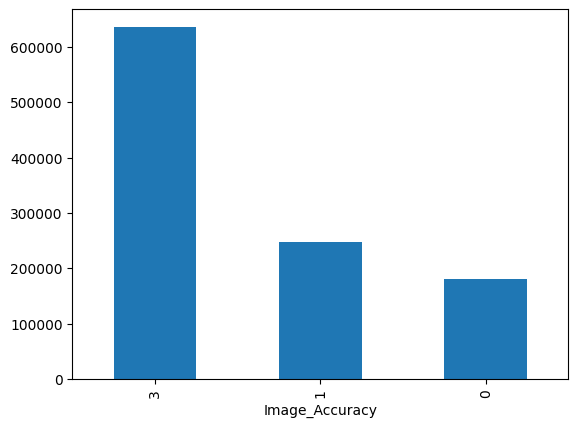

In [18]:
# plot Image_Accuracy
all_contents["Image_Accuracy"].value_counts().plot(kind="bar")

In [2]:
# save
all_contents.to_csv('./contents_merged/all_contents_updated_2.csv', index=False)

NameError: name 'all_contents' is not defined

## Add image accuracy 2 (didnt work yet)

Get set images and set them as the image of the stamp if it doesn't have one yet.

In [69]:
image_accuracy_is_0 = all_contents[all_contents["Image_Accuracy"] == 0]

print(len(image_accuracy_is_0))

# Get counts of each Set_ID
set_id_counts = all_contents["Set_ID"].value_counts()

# Filter out rows with Set_IDs that occur more than once
unique_set_ids = set_id_counts[set_id_counts == 1].index
print(len(unique_set_ids))
unique_rows = image_accuracy_is_0[image_accuracy_is_0["Set_ID"].isin(unique_set_ids)]

print(len(unique_rows))

180827
75055
393


In [76]:
# get all rows where all elements from one Set_ID (from all rows) are 0
# create a list with the names be the set ids and the value be the number of rows with that set id
set_id_counts = all_contents["Set_ID"].value_counts()
# the same for image_accuracy_is_0
set_id_counts_0 = image_accuracy_is_0["Set_ID"].value_counts()
# get the set ids which are in both and have the same value
set_ids = set(set_id_counts.index).intersection(set(set_id_counts_0.index))
# get the set ids which have the same value
set_ids = set_id_counts[list(set_ids)][set_id_counts[list(set_ids)] == set_id_counts_0[list(set_ids)]].index
# get the rows
rows = image_accuracy_is_0[image_accuracy_is_0["Set_ID"].isin(set_ids)]
len(rows)

691

In [ ]:
# loop over all rows where Image_Accuracy is 0 and get the image
for index, row in rows.iterrows():
    url = row["Set_Url"]
    response = requests.get(url)
    if response.status_code == 200:
        html = response.text
    else:
        html = None

    soup = BeautifulSoup(html, 'html.parser')

    # print(soup)

    group_id = row["Set_ID"]

    # print(group_id)

    # print(soup.find("div", id="group_box_" + str(group_id)).findAll("img", class_="img-fluid"))

    # get image url by xpath //*[@id="group_box_256042"]/div[2]/div/span/img
    if len(soup.find("div", id="group_box_" + str(group_id)).findAll("img", class_="img-fluid")) == 1:
        img = soup.find("div", id="group_box_" + str(group_id)).find("img", class_="img-fluid").find("img")
    else:
        img = None

    if img:
        # set url in image_accuracy_is_0
        img_url = img["src"]
        rows.loc[rows["Set_Url"] == url, "Image_URL"] = img_url
        rows.loc[rows["Set_Url"] == url, "Image_Accuracy"] = 2
    else:
        print("No image found for", url)


# Just testing

In [3]:
# load
all_contents = pd.read_csv('./contents_merged/all_contents_updated_2.csv')

C:\Users\Robin\AppData\Local\Temp\ipykernel_27908\1463226466.py:2: DtypeWarning: Columns (13,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  all_contents = pd.read_csv('./contents_merged/all_contents_updated_2.csv')


In [5]:
# print all columns
pd.set_option('display.max_columns', None)
all_contents

,Country,Category,Year,Set_Url,Set_Name,Set_ID,Set_Description,Number,Type,Denomination,Color,Description,Stamps_Issued,Mint_Condition,Unused,Used,Letter/FDC,Currency,Image_URL,Date_of_Issue,Perforations,Sheet_Size,Design,Engraved_By,Height_Width,Themes,Image_Accuracy
0,Aaland,Franking labels,1984,https://www.stampworld.com/stamps/Aaland/Frank...,1984 Franking Label,256031,29. October WM: None Perforation: Imperforated,1,A,10-9890P,brownish red,NaN,NaN,1.50,NaN,1.75,NaN,EUR,/media/catalogue/Aaland/Franking-labels/A-i.jpg,29/10/1984,Imperforated,NaN,NaN,NaN,NaN,['Post & Philately/Postal Services'],3
1,Aaland,Franking labels,1988,https://www.stampworld.com/stamps/Aaland/Frank...,1988 Franking Label,256035,4. January WM: None Perforation: Imperforated,2,B,10-9890P,reddish purple,NaN,NaN,2.00,NaN,2.25,NaN,EUR,/media/catalogue/Aaland/Franking-labels/B-i.jpg,04/01/1988,Imperforated,NaN,NaN,NaN,NaN,['Post & Philately'],3
2,Aaland,Franking labels,1989,https://www.stampworld.com/stamps/Aaland/Frank...,1989 Franking Label,256037,2. January WM: None Perforation: Imperforated,3,C,10-9890P,reddish purple,NaN,NaN,1.50,NaN,1.75,NaN,EUR,/media/catalogue/Aaland/Franking-labels/C-i.jpg,02/01/1989,Imperforated,NaN,NaN,NaN,NaN,[],3
3,Aaland,Franking labels,1989,https://www.stampworld.com/stamps/Aaland/Frank...,1989 Franking Label,256037,2. January WM: None Perforation: Imperforated,3A,C1,10-9890P,reddish purple,Fluorescent paper,NaN,18.00,NaN,10.00,NaN,EUR,/media/catalogue/Aaland/Franking-labels/C1-i.jpg,02/01/1989,Imperforated,NaN,NaN,NaN,NaN,[],3
4,Aaland,Franking labels,1990,https://www.stampworld.com/stamps/Aaland/Frank...,1990 Franking Label,256040,1. March WM: None Perforation: Imperforated,4,D,10-9890P,reddish purple,NaN,NaN,1.25,NaN,1.50,NaN,EUR,/media/catalogue/Aaland/Franking-labels/D-i.jpg,01/03/1990,Imperforated,NaN,NaN,NaN,NaN,[],3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063555,Zurich,Postage stamps,1843,https://www.stampworld.com/stamps/Zurich/Posta...,1843 Value Stamps - Red Vertical Lines,60023,1. March WM: None Sheetsize: 100 Design: Orell...,1,A,4(Rp),black,NaN,(160.000),NaN,"12,000","12,000",NaN,EUR,/media/catalogue/Zurich/Postage-stamps/A-i.jpg,01/03/1843,Imperforated,100,"Orell, Fuessli and Company",Aucun (Lithographie),NaN,['Post & Philately'],3
1063556,Zurich,Postage stamps,1843,https://www.stampworld.com/stamps/Zurich/Posta...,1843 Value Stamps - Red Vertical Lines,60023,1. March WM: None Sheetsize: 100 Design: Orell...,2,B,6(Rp),black,NaN,(160.000),NaN,"5,000","1,200",NaN,EUR,/media/catalogue/Zurich/Postage-stamps/B-i.jpg,01/03/1843,Imperforated,100,"Orell, Fuessli and Company",Aucun (Lithographie),NaN,['Post & Philately'],3
1063557,Zurich,Postage stamps,1843,https://www.stampworld.com/stamps/Zurich/Posta...,1843 Value Stamps - Red Vertical Lines,60023,1. March WM: None Sheetsize: 100 Design: Orell...,1‑2,NaN,NaN,NaN,NaN,NaN,NaN,"17,000","13,200",NaN,EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1063558,Zurich,Postage stamps,1846,https://www.stampworld.com/stamps/Zurich/Posta...,1846 Red Horizontal Lines,60031,1. March WM: None Sheetsize: 100 Design: Orell...,1A,A1,4(Rp),black,NaN,NaN,NaN,"12,000","15,000",NaN,EUR,/media/catalogue/Zurich/Postage-stamps/A1-i.jpg,01/03/1846,Imperforated,100,"Orell, Fuessli and Company",Aucun (Lithographie),NaN,['Post & Philately'],3


In [43]:
# get all themes
all_themes = []
theme_columns = all_contents["Themes"].dropna().values

for themes in theme_columns:
    if themes:
        # remove []
        themes = themes[1:-1]
        # print(themes)
        for theme in themes.split(","):
            current_theme = theme.replace("'", "")
            current_theme = theme.replace('"', "")
            current_theme = current_theme.strip()
            # appen if not empty
            if current_theme:
                all_themes.append(current_theme)

# get unique themes
unique_themes = set(all_themes)

# count how many times each theme occurs
theme_counts = {}
for theme in unique_themes:
    theme_counts[theme] = all_themes.count(theme)

# sort the themes by count
sorted_theme_counts = dict(sorted(theme_counts.items(), key=lambda item: item[1], reverse=True))

In [44]:
# print names of theme
# for theme, count in sorted_theme_counts.items():
#     print(theme, count)

len(sorted_theme_counts)

# create a df form the sorted_theme_counts
themes_df = pd.DataFrame(columns=["Theme", "Count"])
for theme, count in sorted_theme_counts.items():
    themes_df = pd.concat([themes_df, pd.DataFrame([[theme.split("/"), count]], columns=["Theme", "Count"])], ignore_index=True)

In [52]:
# get all first elements in theme
first_elements = []
for index, row in themes_df.iterrows():
    to_add = row["Theme"][0].strip()
    to_add = to_add.replace("'", "")
    to_add = to_add.replace('"', "")
    first_elements.append(to_add)

In [60]:
print(len(set(first_elements)))

# save as txt
with open('./themes.txt', 'w') as f:
    for item in set(first_elements):
        f.write("%s\n" % item)

256


In [10]:
# get all themes which contain art
art_themes = []
for index, row in themes_df.iterrows():
    if "\"Art" in row["Theme"]:
        art_themes.append(row["Theme"])
print(art_themes)

NameError: name 'themes_df' is not defined

In [9]:
# plot top 10 themes
top_10_themes = dict(list(sorted_theme_counts.items())[:10])
plt.bar(top_10_themes.keys(), top_10_themes.values())
plt.xticks(rotation=90)

NameError: name 'sorted_theme_counts' is not defined

In [1]:
# not all!!!
stamp_themes = {
    "Historical Figures": [
        "John 1797-1801", "Harry S. 1945-1953", "Neil", "Severiano", "Vijay", "Isaac", "James Earl 1977-1981", 
        "William Jefferson 1993-2001", "James 1817-1825", "Dwight David 1953-1961", "William Howard 1909-1913", 
        "Theodore 1901-1909", "Ulysses Simpson 1869-1877", "Chester Alan 1881-1885", "Andrew 1829-1837", "James 1857-1861", 
        "Abraham 1861-1865", "Millard 1850-1853", "William Henry 1841", "James Knox 1845-1849", "James Abram 1881", 
        "John Quincy 1825-1829", "James 1809-1817", "George 1789-1797", "Martin Van 1837-1841", "Zachary 1849-1850", 
        "Herbert Clark 1929-1933", "Calvin 1923-1929", "Woodrow 1913-1921", "Benjamin 1889-1893", "Grover 1885-89 & 1893-97", 
        "Rutherford Birchard 1877-1881", "Franklin 1853-1857", "Andrew 1865-1869", "Richard Milhous 1969-1974", 
        "Lyndon Baines 1963-1969", "John Fitzgerald 1961-1963", "James Polk 1845-1849", "Gerald Rudolph 1974-1977", 
        "James Monroe 1817-1825", "Warren Gamaliel 1921-1923", "William McKinley 1897-1901"
    ],
    "Countries and Cities": [
        "Brazil 2016", "Italy 2006", "Belgium 1920", "Canada 1988", "USA 1984", "Germany 1972", "Japan 1972", 
        "Sweden 1952", "Australia 2000", "Switzerland 1928", "Austria 1964", "Finland 1952", "Sweden 1912", 
        "Germany 1936", "Mexico 1968", "Sweden 1952", "USA 2002", "Uruguay", "Japan 1998", "Mexico 1988", "Norway 1994", 
        "Spain 1992", "Netherlands 1928", "Sweden 1952", "Greece 1896", "USA 1984", "Russia 1980", "France 1968"
    ],
    "Events": [
        "USA 1932", "Mexico 1968", "Japan 1964", "USSR 1980", "Germany 1936", "USA 1984", "Australia 2000", 
        "Canada 2010", "Winter Olympics", "Summer Olympics", "Political Events", "Historical Events"
    ],
    "Art and Culture": [
        "Literature", "Movies", "Comics & Cartoons", "Fashion", "Music", "Folklore & Legends", "Art", "Costumes", 
        "Television Series", "Mythology", "Religion", "Architecture"
    ],
    "Science and Technology": [
        "Astronomy", "Mathematics", "Science & Technology", "Space", "Environment", "Medicine", "Technology"
    ],
    "Nature": [
        "Fauna", "Flora", "Environment", "Geology", "Animals", "Plants", "Nature"
    ],
    "Sports": [
        "Olympics", "Car Races", "Sports", "Athletics", "Football", "Cricket", "Tennis", "Baseball", "Basketball"
    ],
    "Symbols and Emblems": [
        "Heraldry", "Seals (Emblems)", "Medals & Orders", "Badges", "Insignia", "Symbols"
    ],
    "Special Interests": [
        "Coins", "Numeral Stamps", "Round Stamps", "Stamp Formats", "Public Service", "Architecture", "Stamps", 
        "Philately", "Post & Philately"
    ],
    "Miscellaneous": [
        "Freemasonry", "Organisations", "EUROPA Stamps", "EUROMED Stamps", "Post & Philately", "Youth", "Work on stamps", 
        "Celebrations", "Maps", "Tourism", "Astrology", "Transport", "WWF", "Scouting", "Education", "Literature", 
        "Industry", "Commerce", "Economics", "Agriculture", "Health", "Geography", "History", "Politics"
    ]
}


In [3]:
stamp_themes.keys()

dict_keys(['Historical Figures', 'Countries and Cities', 'Events', 'Art and Culture', 'Science and Technology', 'Nature', 'Sports', 'Symbols and Emblems', 'Special Interests', 'Miscellaneous'])

In [8]:
# get number of elements in stamp_themes
number_of_elements = 0
for key, value in stamp_themes.items():
    number_of_elements += len(value)
print(number_of_elements)

NameError: name 'stamp_themes' is not defined